### Sea Ice Trends in Models, Reanalyses, and Observations

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy as ccrs
import glob
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from scipy import signal

# Old stuff

In [2]:
file_path_unique = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical'
ensemble = ['d20190308', 'd20190308', 'd20190308', 'd20190308', 'd20190308', 'd20190308','d20190311','d20190311','d20190311','d20190313', 'd20190514',]  


In [3]:
def read_cesm2(variable, file_path_unique):
    # set the filepath, which the progression of directories that leads to where your data is stored

    # initalize an empty list, which we will use to store data from each individual ensemble member while we open the files 
    data_list = []

    # begin a loop that will cycle through each of the ensemble members (there are 11 for CESM2)
    for i in range(1,12): 
        file_path = '/'+'r{0}i1p1f1'.format(i)+'/SImon/'+variable+'/gn/files/'+ensemble[i-1]+'/'
        files = [] 
        files = sorted(glob.glob(file_path_unique + file_path + variable +'_SImon_CESM2_historical_r{0}i1p1f1_gn_*[0-9]*-*[0-9]*.nc'.format(i)))
        if len(files) == 0: 
            file = file_path_unique + file_path + variable +'_SImon_CESM2_historical_r{0}i1p1f1_gn_185001-201412.nc'.format(i)
            # print(file)
            data = xr.open_dataset(file)
        else:
            # print(files)
            data = xr.open_mfdataset(files, combine='by_coords')
    
        data_list.append(data)

    dataset = xr.concat(data_list, dim = 'realization')
    dataset = dataset.mean(dim = 'realization')
    return dataset


In [4]:
SIT = read_cesm2('sithick',file_path_unique)
SIC = read_cesm2('siconc', file_path_unique)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/conventions.py:52

In [5]:
Arctic_SIT = SIT.where(SIT.lat > 0)
Antarctic_SIT = SIT.where(SIT.lat < 0)

Arctic_SIV = Arctic_SIT.sum(dim = ['ni','nj'])
Antarctic_SIV = Antarctic_SIT.sum(dim = ['ni','nj'])

In [6]:
Arctic_SIT

<xarray.Dataset>
Dimensions:   (ni: 320, nj: 384, nvertices: 4, time: 1980)
Coordinates:
    lat       (nj, ni) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    lon       (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
  * ni        (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj        (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time      (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nvertices
Data variables:
    sithick   (time, nj, ni) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    lat_bnds  (nj, ni, nvertices, time) float32 dask.array<chunksize=(384, 320, 4, 600), meta=np.ndarray>
    lon_bnds  (nj, ni, nvertices, time) float32 dask.array<chunksize=(384, 320, 4, 600), meta=np.ndarray>

In [7]:
Arctic_SIT_mean = Arctic_SIT.sithick.mean(dim = ['ni','nj'])

In [95]:
deseasonalized_SIC = Arctic_SIC.groupby('time.month') - Arctic_SIC.groupby('time.month').mean(dim='time')

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


In [10]:
def haleys_detrend(data, deg):
#     data = Arctic_SIT_eff
    # Grouping months 
    # month2 = data.groupby('time.month')[month]
    data = data.groupby('time.month') - data.groupby('time.month').mean(dim='time')
    # Finding polyfit of that month
    polyfit = data.polyfit(dim='time', deg=deg) #, skipna=True)
    # Polyval 
    trend = xr.polyval(data.time, polyfit.polyfit_coefficients)
    # subtract trendline from data 
    anoms = data-trend 

    slope = (trend[-1] - trend[0])/len(trend)
    return anoms, trend, slope

In [11]:
anomalies, trend, slope = haleys_detrend(Arctic_SIT.sithick, 1)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


In [12]:
slope.load()

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit m

<xarray.DataArray (nj: 384, ni: 320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * nj       (nj) int64 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * ni       (ni) int64 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320

Temporal Trend Graph

In [ ]:
inplaceSIT = Arctic_SIT.sithick.mean(dim=['ni','nj']).compute()

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [72]:
avgd_SIT = inplaceSIT.rolling(time=120, center=True).mean()

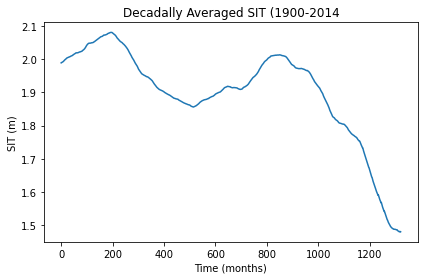

In [80]:
date_start = '1900-01-01' 
date_end =  '2014-12-31'
plt.plot(avgd_SIT.sel(time = slice(date_start, date_end)))
plt.xlabel('Time (months)')
plt.ylabel('SIT (m)')
plt.title('Decadally Averaged SIT (1900-2014)')
plt.tight_layout()
plt.tight_layout()

In [74]:
mean_slope = avgd_SIT.differentiate('time')

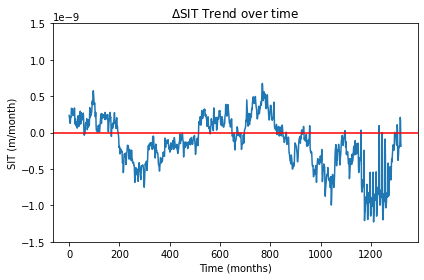

In [83]:
date_start = '1900-01-01' 
date_end =  '2014-12-31'
Arctic_SIT_plot = mean_slope.sel(time = slice(date_start, date_end))
plt.plot(Arctic_SIT_plot)
plt.axhline(y=0, c='red')
plt.ylim([-1.5e-9, 1.5e-9])
plt.xlabel('Time (months)')
plt.ylabel('SIT (m/month)')
plt.title('$\Delta$SIT Trend over time')
plt.tight_layout()

Trend Spactial Mapping

In [13]:
old_data  = slope
longitude = Arctic_SIT.lon
latitude = Arctic_SIT.lat

In [14]:
proj = ccrs.NorthPolarStereo()

# call the *tranform_points* method to the projection object you just assigned
# this method will convert the lat,lon data that you have to a new set that are consistent with the projection
coords = proj.transform_points(ccrs.PlateCarree(), np.array(longitude), np.array(latitude))

# use the numpy.ma package, which creates masked arrays. A masked array tells future calculations to avoid 
# performing calculations over consistent areas with no data (usually filled in the Not-A-Numbers, or NaNs)

# first apply this masking to latitude and longitude, which are stored in the zeroth and first indices of coords
x = np.ma.masked_invalid(coords[..., 0])
y = np.ma.masked_invalid(coords[..., 1])

# now apply this masking to the data itself
new_data = np.ma.masked_invalid(old_data)

# save the total mask as any location where the data, the latitude, or the longitude are masked (have value 1)
new_data.mask = np.logical_or(new_data.mask, x.mask, y.mask)

# fill the missing data with zeros
x = x.filled(0)
y = y.filled(0)


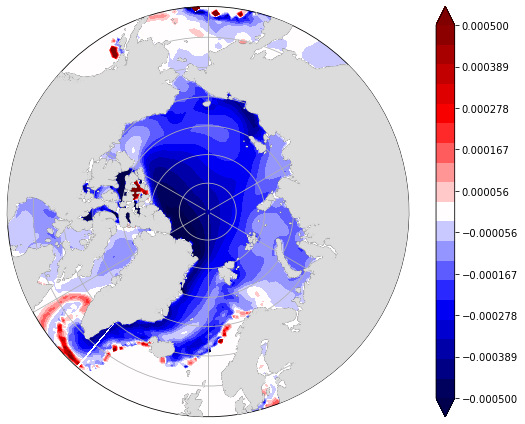

In [21]:
# set up figure 
fig = plt.figure(figsize=(8,6))

# in order to make a projection, you need to assign the projection to an axis and plot onto that axis
ax = plt.axes(projection=proj)

#========DECORATIONS===========#
# # 1. set the geographic bound (left longitude, right longitude, low latitude, high latitude) and transform into cartopy
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())

# # 2. put coastlines on your map
ax.coastlines()

# # 3. add in land features on your map, setting them to be 6th priority order (behind most things on the plot, except the data)
ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)

# # 4. add gridlines to your map
ax.gridlines()

# # 5. define a circle 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

# # 6. set a circular boundary on the map
ax.set_boundary(circle, transform=ax.transAxes)
#===============================#

# choose a colormap for your plot (you can find more here: https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html)
cmap = plt.cm.seismic
bounds = [0, 0.5]
clevs_label = np.linspace(-5e-4, 5e-4, 10)
clevs = np.linspace(-5e-4, 5e-4, 20)

# plot the data using a smooth surface function called contourf (you can read more here: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.contourf.html)
img = ax.contourf(x, y, new_data, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend='both')
fig.colorbar(img, ax=ax, ticks= clevs_label)

# label your figure (replace with the name of your variable)
plt.title('', fontweight='bold', fontsize=14, pad= 25)
# force the figure to output nicely
plt.tight_layout()

SD spatial plotting

In [22]:
thickness_SD = anomalies.std(dim='time', skipna=True).compute()

/glade/u/home/mollyw/.conda/envs/single_assimilation/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit m

In [23]:
thickness_SD

<xarray.DataArray (nj: 384, ni: 320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat      (nj, ni) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    lon      (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
  * ni       (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj       (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384

In [25]:
old_data  = thickness_SD
longitude = thickness_SD.lon
latitude = thickness_SD.lat

In [26]:
proj = ccrs.NorthPolarStereo()

# call the *tranform_points* method to the projection object you just assigned
# this method will convert the lat,lon data that you have to a new set that are consistent with the projection
coords = proj.transform_points(ccrs.PlateCarree(),np.array(longitude), np.array(latitude))

# use the numpy.ma package, which creates masked arrays. A masked array tells future calculations to avoid 
# performing calculations over consistent areas with no data (usually filled in the Not-A-Numbers, or NaNs)

# first apply this masking to latitude and longitude, which are stored in the zeroth and first indices of coords
x = np.ma.masked_invalid(coords[..., 0])
y = np.ma.masked_invalid(coords[..., 1])

# now apply this masking to the data itself
new_data = np.ma.masked_invalid(old_data)

# save the total mask as any location where the data, the latitude, or the longitude are masked (have value 1)
new_data.mask = np.logical_or(new_data.mask, x.mask, y.mask)

# fill the missing data with zeros
x = x.filled(0)
y = y.filled(0)
    

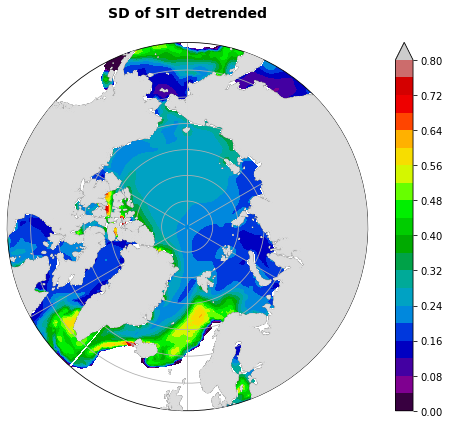

In [33]:
# set up figure 
fig = plt.figure(figsize=(8,6))

# in order to make a projection, you need to assign the projection to an axis and plot onto that axis
ax = plt.axes(projection=proj)

#========DECORATIONS===========#
# # 1. set the geographic bound (left longitude, right longitude, low latitude, high latitude) and transform into cartopy
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())

# # 2. put coastlines on your map
ax.coastlines()

# # 3. add in land features on your map, setting them to be 6th priority order (behind most things on the plot, except the data)
ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)

# # 4. add gridlines to your map
ax.gridlines()

# # 5. define a circle 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

# # 6. set a circular boundary on the map
ax.set_boundary(circle, transform=ax.transAxes)
#===============================#

# choose a colormap for your plot (you can find more here: https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html)
cmap = plt.cm.nipy_spectral
bounds = [0, 10]
clevs_label = np.linspace(0, 0.8, 11)
clevs = np.linspace(0, 0.8, 21)

# plot the data using a smooth surface function called contourf (you can read more here: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.contourf.html)
img = ax.contourf(x, y, new_data, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend='max')
fig.colorbar(img, ax=ax, ticks= clevs_label)

# label your figure (replace with the name of your variable)
plt.title('SD of SIT detrended', fontweight='bold', fontsize=14, pad= 25)
# force the figure to output nicely
plt.tight_layout()

## Questions/Notes

* BW/Roach paper, take ensemble mean to take out interenal variability. When I do that, aren't I finding internal variability? 
* 

# SIC

### Read data

In [208]:
sit_files = sorted(glob.glob('/glade/work/mollyw/Haley_Data/SIT/PIOMAS/*'))
sic_files = sorted(glob.glob('/glade/work/mollyw/Haley_Data/SIC/PIOMAS/*'))

data = xr.open_mfdataset(sit_files, combine='nested', concat_dim = 't')
sicdata = xr.open_mfdataset(sic_files, combine='nested', concat_dim = 't')

In [209]:
data['concentration'] = sicdata.area

In [2]:
time = pd.date_range('1979-01-01','2021-12-31')

In [3]:
time

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=15706, freq='D')

In [203]:
time = []
count = 0
for year in range(1979,2022):
    time_list = pd.date_range(str(year)+'-01-01', str(year)+'-12-31', freq = "D")
    if len(time_list) > 365:
        # print(year)
        feb = pd.date_range(str(year)+'-02-01',  str(year)+'-02-29')
        time.append(time_list.drop(feb[-1]).values) #.append([t for t in time_list if t != feb[-1]])
    else:
        time.append(time_list.values)
    count += 1
    
time = np.concatenate(time)

In [216]:
data['t'] = time

In [218]:
data = data.drop('day')

### Define functions

In [60]:
def detrend(data, deg):

    polyfit = data.polyfit(dim='t', deg=deg) #, skipna=True)
    # print(polyfit)
    # Polyval 
    trend = xr.polyval(data.t, polyfit.polyfit_coefficients)
    # subtract trendline from data 
    anoms = data-trend 

    slope = (trend[-1] - trend[0])/len(trend)
    
    return anoms, trend, slope

In [61]:
def get_slopes(data):
    months = data.groupby('t.month')
    ANOMS = []
    TRENDS = []
    SLOPES = []
    for i in range(0,12):
        month = months[i+1]
        anoms, trend, slope = detrend(month, 1)
        ANOMS.append(anoms)
        TRENDS.append(trend)
        SLOPES.append(slope)
        
    return TRENDS, SLOPES

### Calculate monthly trends

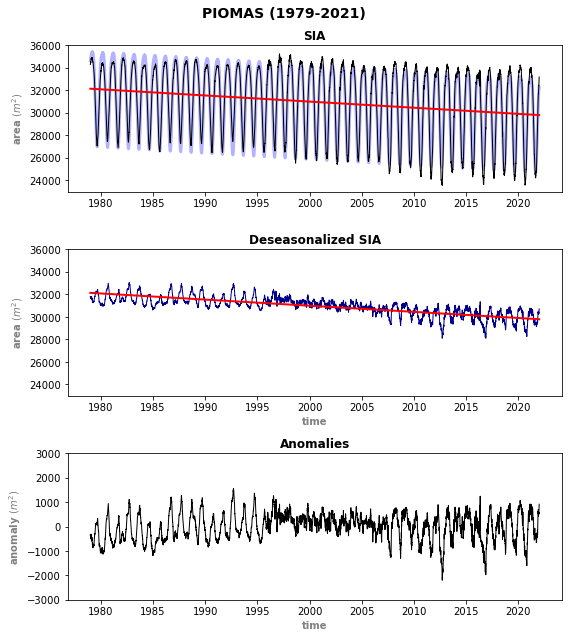

In [181]:
anoms, trend, slope = detrend(sic.area, 1)
detrended = sic.area - trend
seasonal_cycle = detrended.groupby('t.dayofyear').mean(dim='t')
deseasonalized = sic.area.groupby('t.dayofyear') - seasonal_cycle
detrended_deseasonalized = detrended.groupby('t.dayofyear') - seasonal_cycle


fig, axes = plt.subplots(nrows = 3, figsize=(8,9))
axes[0].plot(sic.t, sic.area - detrended_deseasonalized, color = 'blue', linewidth = 3, alpha = 0.3, label = 'seasonal cycle')
axes[0].plot(sic.t, sic.area, color = 'black', linewidth = 1, label = 'piomas data')
axes[0].plot(sic.t, trend, color = 'red', linewidth = 2, label = 'trend')
axes[0].set_ylim([23000, 36000])

axes[0].set_title('SIA', fontweight='bold', fontsize=12)
# axes[0].set_xlabel('time', fontweight='bold', color = 'grey')
axes[0].set_ylabel('area $(m^2)$', fontweight='bold', color = 'grey')

axes[1].plot(sic.t, deseasonalized, color = 'darkblue', linewidth = 1, label = 'sia anomalies')
axes[1].plot(sic.t, trend, color = 'red', linewidth = 2, label = 'trend')
axes[1].set_title('Deseasonalized SIA', fontweight='bold', fontsize=12)
axes[1].set_xlabel('time', fontweight='bold', color = 'grey')
axes[1].set_ylabel('area $(m^2)$', fontweight='bold', color = 'grey')
axes[1].set_ylim([23000, 36000])

axes[2].plot(sic.t, detrended_deseasonalized, color = 'black', linewidth = 1, label = 'sia anomalies')
axes[2].set_title('Anomalies', fontweight='bold', fontsize=12)
axes[2].set_ylim([-3000, 3000])
axes[2].set_xlabel('time', fontweight='bold', color = 'grey')
axes[2].set_ylabel('anomaly $(m^2)$', fontweight='bold', color = 'grey')

plt.suptitle('PIOMAS (1979-2021)', fontweight='bold', fontsize=14)
plt.tight_layout()

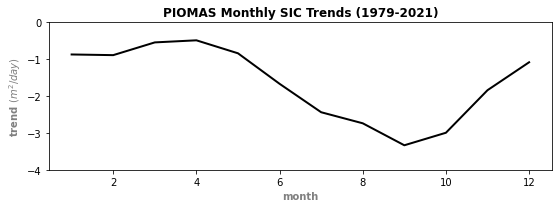

In [184]:
trends, slopes_sc = get_slopes(deseasonalized)

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(1,13), slopes_sc, linewidth = 2, color = 'black')
plt.ylim([-4, 0])
plt.ylabel('trend $(m^2/day)$', fontweight='bold', color = 'grey')
plt.xlabel('month', fontweight='bold', color = 'grey')

plt.title('PIOMAS Monthly SIC Trends (1979-2021)', fontweight='bold', fontsize=12)
plt.tight_layout()

### Explore seasonal cycle shifts

In [119]:
days = np.arange(0,366)

In [120]:
seasonal_cycle79_89 = sic.isel(t = slice(0, 365*10)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle84_94 = sic.isel(t = slice(365*5, 365*15)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle89_99 = sic.isel(t = slice(365*10, 365*20)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle94_04 = sic.isel(t = slice(365*15, 365*25)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle99_09 = sic.isel(t = slice(365*20, 365*30)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle04_14 = sic.isel(t = slice(365*25, 365*35)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle09_19 = sic.isel(t = slice(365*30, 365*40)).groupby('t.dayofyear').mean(dim='t')

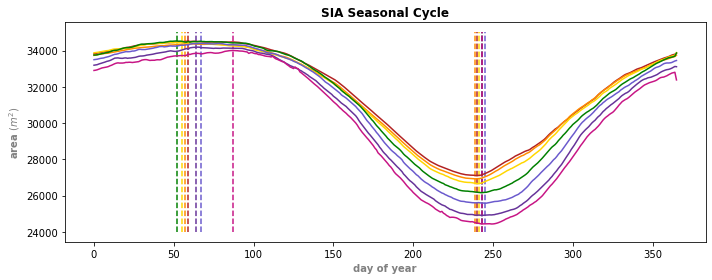

In [151]:
fig = plt.figure(figsize=(10,4))

plt.plot(days, seasonal_cycle79_89.area, c = 'firebrick')
plt.plot(days, seasonal_cycle84_94.area, c = 'darkorange')
plt.plot(days, seasonal_cycle89_99.area, c = 'gold')
plt.plot(days, seasonal_cycle94_04.area, c = 'green')
plt.plot(days, seasonal_cycle99_09.area, c = 'slateblue')
plt.plot(days, seasonal_cycle04_14.area, c = 'rebeccapurple')
plt.plot(days, seasonal_cycle09_19.area, c = 'mediumvioletred')

plt.vlines(x = days[seasonal_cycle79_89.area == seasonal_cycle79_89.area.max()], ymin = 24000, ymax=35000, color = 'firebrick', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle79_89.area == seasonal_cycle79_89.area.min()], ymin = 24000, ymax=35000, color = 'firebrick',  linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle84_94.area == seasonal_cycle84_94.area.max()], ymin = 24000, ymax=35000, color = 'darkorange',  linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle84_94.area == seasonal_cycle84_94.area.min()], ymin = 24000, ymax=35000, color = 'darkorange', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle89_99.area == seasonal_cycle89_99.area.max()], ymin = 24000, ymax=35000, color = 'gold', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle89_99.area == seasonal_cycle89_99.area.min()], ymin = 24000, ymax=35000, color = 'gold', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle94_04.area == seasonal_cycle94_04.area.max()], ymin = 24000, ymax=35000, color = 'green', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle94_04.area == seasonal_cycle94_04.area.min()], ymin = 24000, ymax=35000, color = 'green', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle99_09.area == seasonal_cycle99_09.area.max()], ymin = 24000, ymax=35000, color = 'slateblue', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle99_09.area == seasonal_cycle99_09.area.min()], ymin = 24000, ymax=35000, color = 'slateblue', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle04_14.area == seasonal_cycle04_14.area.max()], ymin = 24000, ymax=35000, color = 'rebeccapurple', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle04_14.area == seasonal_cycle04_14.area.min()], ymin = 24000, ymax=35000, color = 'rebeccapurple', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle09_19.area == seasonal_cycle09_19.area.max()], ymin = 24000, ymax=35000, color = 'mediumvioletred', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle09_19.area == seasonal_cycle09_19.area.min()], ymin = 24000, ymax=35000, color = 'mediumvioletred', linestyle = 'dashed')

plt.title('SIA Seasonal Cycle', fontweight='bold', fontsize=12)
plt.ylabel('area $(m^2)$', fontweight='bold', color = 'grey')
plt.xlabel('day of year', fontweight='bold', color = 'grey')

plt.tight_layout()

In [133]:
deseasonalized1 = sic.groupby('t.dayofyear') - seasonal_cycle79_89
deseasonalized2 = sic.groupby('t.dayofyear') - seasonal_cycle89_99
deseasonalized3 = sic.groupby('t.dayofyear') - seasonal_cycle99_09
deseasonalized4 = sic.groupby('t.dayofyear') - seasonal_cycle09_19

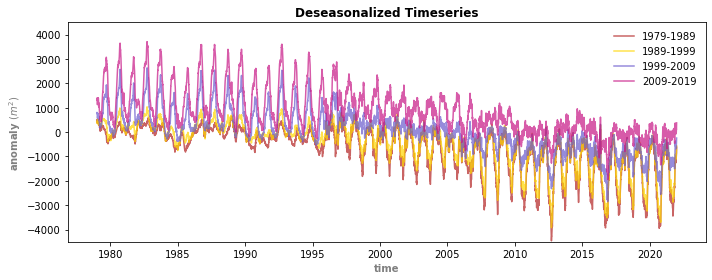

In [149]:
fig = plt.figure(figsize=(10,4))

plt.plot(deseasonalized1.t, deseasonalized1.area, alpha = 0.7, color = 'firebrick', label = '1979-1989')
plt.plot(deseasonalized2.t, deseasonalized2.area, alpha = 0.7, color = 'gold', label = '1989-1999')
plt.plot(deseasonalized3.t, deseasonalized3.area, alpha = 0.7, color = 'slateblue', label = '1999-2009')
plt.plot(deseasonalized4.t, deseasonalized4.area, alpha = 0.7, color = 'mediumvioletred', label = '2009-2019')

plt.ylim([-4500, 4500])
plt.ylabel('anomaly $(m^2)$', fontweight='bold', color = 'grey')
plt.xlabel('time', fontweight='bold', color = 'grey')

plt.legend(frameon=False)
plt.title('Deseasonalized Timeseries', fontweight='bold', fontsize=12)

plt.tight_layout()

In [154]:
cycle_list = [deseasonalized1, deseasonalized2,
              deseasonalized3, deseasonalized4]

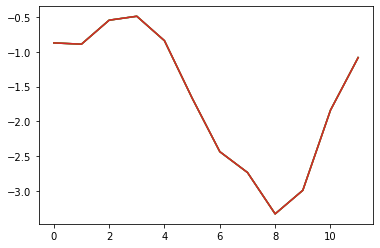

In [156]:
for item in cycle_list:
    trend, slopes = get_slopes(item)
    plt.plot(slopes)

### Remove seasonal cycle by filtering

In [186]:
inter = 365
annual_sos = signal.butter(4, [1/(inter*2) * 2, 1/(inter*0.5) * 2], 'bs', output='sos')
minus_annual = signal.sosfilt(annual_sos, sic.area)

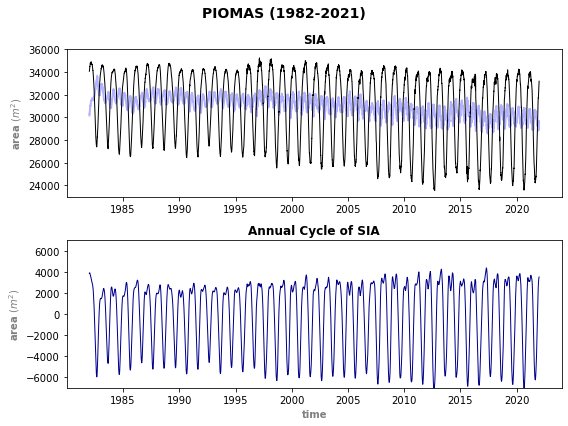

In [188]:
fig, axes = plt.subplots(nrows = 2, figsize=(8,6))
axes[0].plot(sic.t[365*3:], minus_annual[365*3:], color = 'blue', linewidth = 2, alpha = 0.3, label = 'seasonal cycle')
axes[0].plot(sic.t[365*3:], sic.area[365*3:], color = 'black', linewidth = 1, label = 'piomas data')
# axes[0].plot(sic.t, trend, color = 'red', linewidth = 2, label = 'trend')
axes[0].set_ylim([23000, 36000])
axes[0].set_title('SIA', fontweight='bold', fontsize=12)
axes[0].set_ylabel('area $(m^2)$', fontweight='bold', color = 'grey')

axes[1].plot(sic.t[365*3:], sic.area[365*3:] - minus_annual[365*3:], color = 'darkblue', linewidth = 1, label = 'sia anomalies')
axes[1].set_title('Annual Cycle of SIA', fontweight='bold', fontsize=12)
axes[1].set_xlabel('time', fontweight='bold', color = 'grey')
axes[1].set_ylabel('area $(m^2)$', fontweight='bold', color = 'grey')
axes[1].set_ylim([-7000, 7000])

plt.suptitle('PIOMAS (1982-2021)', fontweight='bold', fontsize=14)
plt.tight_layout()

In [197]:
deseasonalized = xr.DataArray(data=minus_annual[365*3:],dims=["t"])
sic_detrend = sic.isel(t = slice(365*3,15695))
sic_detrend['area'] = deseasonalized

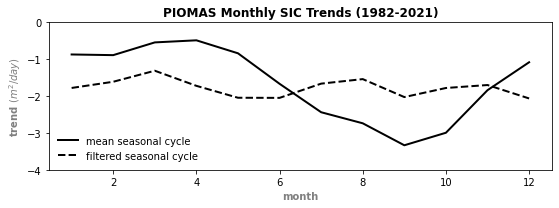

In [198]:
trend, slopes_filt = get_slopes(sic_detrend.area)

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(1,13), slopes_sc, linewidth = 2, color = 'black', label = 'mean seasonal cycle')
plt.plot(np.arange(1,13), slopes_filt, linewidth = 2, color = 'black', linestyle='dashed', label = 'filtered seasonal cycle')
plt.ylim([-4, 0])
plt.ylabel('trend $(m^2/day)$', fontweight='bold', color = 'grey')
plt.xlabel('month', fontweight='bold', color = 'grey')
plt.legend(frameon=False, loc = 'lower left')

plt.title('PIOMAS Monthly SIA Trends (1982-2021)', fontweight='bold', fontsize=12)
plt.tight_layout()

# SIT

### Calculate monthly trends

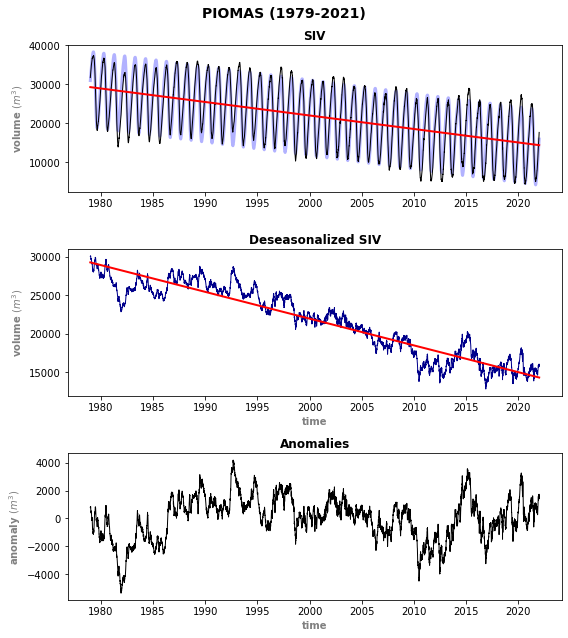

In [133]:
anoms, trend, slope = detrend(SIT.volume, 1)
detrended = SIT.volume - trend
seasonal_cycle = detrended.groupby('t.dayofyear').mean(dim='t')
deseasonalized = SIT.volume.groupby('t.dayofyear') - seasonal_cycle
detrended_deseasonalized = detrended.groupby('t.dayofyear') - seasonal_cycle


fig, axes = plt.subplots(nrows = 3, figsize=(8,9))
axes[0].plot(SIT.t, SIT.volume - detrended_deseasonalized, color = 'blue', linewidth = 3, alpha = 0.3, label = 'seasonal cycle')
axes[0].plot(SIT.t, SIT.volume, color = 'black', linewidth = 1, label = 'piomas data')
axes[0].plot(SIT.t, trend, color = 'red', linewidth = 2, label = 'trend')
# axes[0].set_ylim([23000, 36000])

axes[0].set_title('SIV', fontweight='bold', fontsize=12)
# axes[0].set_xlabel('time', fontweight='bold', color = 'grey')
axes[0].set_ylabel('volume $(m^3)$', fontweight='bold', color = 'grey')

axes[1].plot(SIT.t, deseasonalized, color = 'darkblue', linewidth = 1, label = 'sia anomalies')
axes[1].plot(SIT.t, trend, color = 'red', linewidth = 2, label = 'trend')
axes[1].set_title('Deseasonalized SIV', fontweight='bold', fontsize=12)
axes[1].set_xlabel('time', fontweight='bold', color = 'grey')
axes[1].set_ylabel('volume $(m^3)$', fontweight='bold', color = 'grey')
# axes[1].set_ylim([23000, 36000])

axes[2].plot(SIT.t, detrended_deseasonalized, color = 'black', linewidth = 1, label = 'sia anomalies')
axes[2].set_title('Anomalies', fontweight='bold', fontsize=12)
# axes[2].set_ylim([-3000, 3000])
axes[2].set_xlabel('time', fontweight='bold', color = 'grey')
axes[2].set_ylabel('anomaly $(m^3)$', fontweight='bold', color = 'grey')

plt.suptitle('PIOMAS (1979-2021)', fontweight='bold', fontsize=14)
plt.tight_layout()

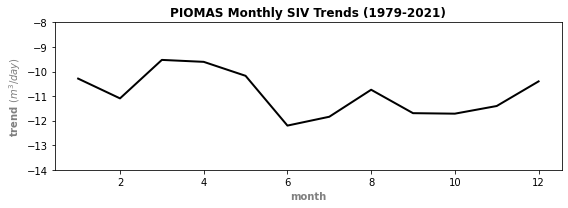

In [138]:
trends, slopes_sc = get_slopes(deseasonalized)

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(1,13), slopes_sc, linewidth = 2, color = 'black')
plt.ylim([-14, -8])
plt.ylabel('trend $(m^3/day)$', fontweight='bold', color = 'grey')
plt.xlabel('month', fontweight='bold', color = 'grey')

plt.title('PIOMAS Monthly SIV Trends (1979-2021)', fontweight='bold', fontsize=12)
plt.tight_layout()

### Explore seasonal cycle shifts

In [139]:
days = np.arange(0,366)

In [140]:
seasonal_cycle79_89 = SIT.volume.isel(t = slice(0, 365*10)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle84_94 = SIT.volume.isel(t = slice(365*5, 365*15)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle89_99 = SIT.volume.isel(t = slice(365*10, 365*20)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle94_04 = SIT.volume.isel(t = slice(365*15, 365*25)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle99_09 = SIT.volume.isel(t = slice(365*20, 365*30)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle04_14 = SIT.volume.isel(t = slice(365*25, 365*35)).groupby('t.dayofyear').mean(dim='t')
seasonal_cycle09_19 = SIT.volume.isel(t = slice(365*30, 365*40)).groupby('t.dayofyear').mean(dim='t')

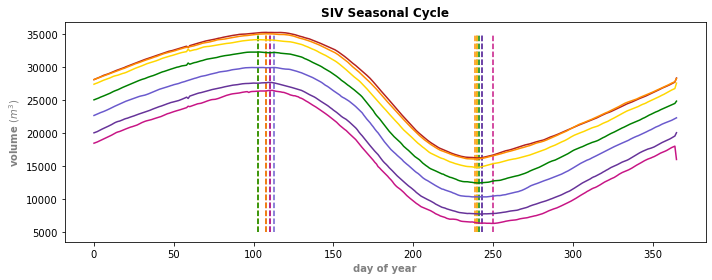

In [153]:
fig = plt.figure(figsize=(10,4))

plt.plot(days, seasonal_cycle79_89, c = 'firebrick')
plt.plot(days, seasonal_cycle84_94, c = 'darkorange')
plt.plot(days, seasonal_cycle89_99, c = 'gold')
plt.plot(days, seasonal_cycle94_04, c = 'green')
plt.plot(days, seasonal_cycle99_09, c = 'slateblue')
plt.plot(days, seasonal_cycle04_14, c = 'rebeccapurple')
plt.plot(days, seasonal_cycle09_19, c = 'mediumvioletred')

plt.vlines(x = days[seasonal_cycle79_89 == seasonal_cycle79_89.max()], ymin = 5000, ymax=35000, color = 'firebrick', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle79_89 == seasonal_cycle79_89.min()], ymin = 5000, ymax=35000, color = 'firebrick',  linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle84_94 == seasonal_cycle84_94.max()], ymin = 5000, ymax=35000, color = 'darkorange',  linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle84_94 == seasonal_cycle84_94.min()], ymin = 5000, ymax=35000, color = 'darkorange', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle89_99 == seasonal_cycle89_99.max()], ymin = 5000, ymax=35000, color = 'gold', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle89_99 == seasonal_cycle89_99.min()], ymin = 5000, ymax=35000, color = 'gold', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle94_04 == seasonal_cycle94_04.max()], ymin = 5000, ymax=35000, color = 'green', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle94_04 == seasonal_cycle94_04.min()], ymin = 5000, ymax=35000, color = 'green', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle99_09 == seasonal_cycle99_09.max()], ymin = 5000, ymax=35000, color = 'slateblue', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle99_09 == seasonal_cycle99_09.min()], ymin = 5000, ymax=35000, color = 'slateblue', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle04_14 == seasonal_cycle04_14.max()], ymin = 5000, ymax=35000, color = 'rebeccapurple', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle04_14 == seasonal_cycle04_14.min()], ymin = 5000, ymax=35000, color = 'rebeccapurple', linestyle = 'dashed')

plt.vlines(x = days[seasonal_cycle09_19 == seasonal_cycle09_19.max()], ymin = 5000, ymax=35000, color = 'mediumvioletred', linestyle = 'dashed')
plt.vlines(x = days[seasonal_cycle09_19 == seasonal_cycle09_19.min()], ymin = 5000, ymax=35000, color = 'mediumvioletred', linestyle = 'dashed')

plt.title('SIV Seasonal Cycle', fontweight='bold', fontsize=12)
plt.ylabel('volume $(m^3)$', fontweight='bold', color = 'grey')
plt.xlabel('day of year', fontweight='bold', color = 'grey')

plt.tight_layout()

In [144]:
deseasonalized1 = SIT.volume.groupby('t.dayofyear') - seasonal_cycle79_89
deseasonalized2 = SIT.volume.groupby('t.dayofyear') - seasonal_cycle89_99
deseasonalized3 = SIT.volume.groupby('t.dayofyear') - seasonal_cycle99_09
deseasonalized4 = SIT.volume.groupby('t.dayofyear') - seasonal_cycle09_19

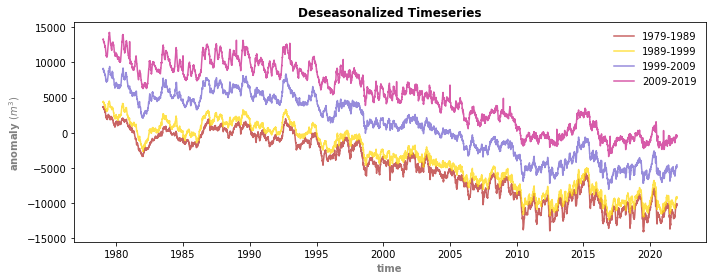

In [154]:
fig = plt.figure(figsize=(10,4))

plt.plot(deseasonalized1.t, deseasonalized1, alpha = 0.7, color = 'firebrick', label = '1979-1989')
plt.plot(deseasonalized2.t, deseasonalized2, alpha = 0.7, color = 'gold', label = '1989-1999')
plt.plot(deseasonalized3.t, deseasonalized3, alpha = 0.7, color = 'slateblue', label = '1999-2009')
plt.plot(deseasonalized4.t, deseasonalized4, alpha = 0.7, color = 'mediumvioletred', label = '2009-2019')

# plt.ylim([-4500, 4500])
plt.ylabel('anomaly $(m^3)$', fontweight='bold', color = 'grey')
plt.xlabel('time', fontweight='bold', color = 'grey')

plt.legend(frameon=False)
plt.title('Deseasonalized Timeseries', fontweight='bold', fontsize=12)

plt.tight_layout()

### Remove seasonal cycle by filtering

In [147]:
inter = 365
annual_sos = signal.butter(4, [1/(inter*2) * 2, 1/(inter*0.5) * 2], 'bs', output='sos')
minus_annual = signal.sosfilt(annual_sos, SIT.volume)

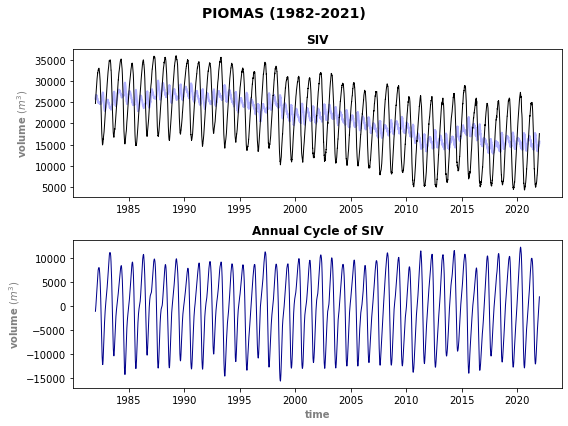

In [155]:
fig, axes = plt.subplots(nrows = 2, figsize=(8,6))
axes[0].plot(SIT.t[365*3:], minus_annual[365*3:], color = 'blue', linewidth = 2, alpha = 0.3, label = 'seasonal cycle')
axes[0].plot(SIT.t[365*3:], SIT.volume[365*3:], color = 'black', linewidth = 1, label = 'piomas data')
# axes[0].plot(sic.t, trend, color = 'red', linewidth = 2, label = 'trend')
# axes[0].set_ylim([23000, 36000])
axes[0].set_title('SIV', fontweight='bold', fontsize=12)
axes[0].set_ylabel('volume $(m^3)$', fontweight='bold', color = 'grey')

axes[1].plot(SIT.t[365*3:], SIT.volume[365*3:] - minus_annual[365*3:], color = 'darkblue', linewidth = 1, label = 'sia anomalies')
axes[1].set_title('Annual Cycle of SIV', fontweight='bold', fontsize=12)
axes[1].set_xlabel('time', fontweight='bold', color = 'grey')
axes[1].set_ylabel('volume $(m^3)$', fontweight='bold', color = 'grey')
# axes[1].set_ylim([-7000, 7000])

plt.suptitle('PIOMAS (1982-2021)', fontweight='bold', fontsize=14)
plt.tight_layout()

In [150]:
deseasonalized = xr.DataArray(data=minus_annual[365*3:],dims=["t"])
siv_detrend = SIT.volume.isel(t = slice(365*3,15695))
siv_detrend['volume'] = deseasonalized

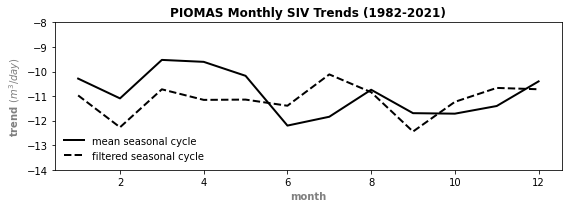

In [152]:
trend, slopes_filt = get_slopes(siv_detrend.volume)

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(1,13), slopes_sc, linewidth = 2, color = 'black', label = 'mean seasonal cycle')
plt.plot(np.arange(1,13), slopes_filt, linewidth = 2, color = 'black', linestyle='dashed', label = 'filtered seasonal cycle')
plt.ylim([-14, -8])
plt.ylabel('trend $(m^3/day)$', fontweight='bold', color = 'grey')
plt.xlabel('month', fontweight='bold', color = 'grey')
plt.legend(frameon=False, loc = 'lower left')

plt.title('PIOMAS Monthly SIV Trends (1982-2021)', fontweight='bold', fontsize=12)
plt.tight_layout()